#Marked exercises after Lecture 10 on GANs

This notebook contains the marked exercises with instructions and explanations.

Work through the cells below in sequential order, executing each cell as you progress. Throughout the exercise, you will encounter instructions marked with the words **YOUR CODE HERE** followed by **raise NotImplementedError()**. You will have to substitute  *raise NotImplementedError()* with your own code.
Follow the instructions and write the code to complete the tasks.

Along the way, you may also find questions. Try to reflect on the questions before/after running the code.

This notebook was developed at the [Idiap Research Institute](https://www.idiap.ch) by [Alina Elena Baia](mailto:alina.baia.idiap.ch>), [Darya Baranouskaya](mailto:darya.baranouskaya.idiap.ch) and [Olena Hrynenko](mailto:olena.hrynenko.idiap.ch) (equal contribution).

Note: This notebook serves as the main file for the marked exercise and contains  the  code for initialising the models, initialising the dataset, setting the hyperparameters for training, and training the model. No code implementation is required in this notebook file. You are allowed to change hyperparameters.

Make sure to upload the required source files. You will be asked to modified these files in order to complete the tasks.

You are asked to complete the following tasks related to completing the implementation of a GAN model and its training function, training
WGAN [40 points]
 - 2.10.1 [3 points] Implement DiscriminatorBlock in model.py.
 - 2.10.2 [5 points] Implement GeneratorBlock in model.py.
 - 2.10.3 [5 points] Compete Generator in model.py: specify kernel_sizes, stride_sizes, padding_sizes in Generator def __init__.
 - 2.10.4 [3 points] Implement weight clamping in trainer.py: def clamp_weights(self)
 - 2.10.5 [9 points] Implement Discriminator update step in trainer.py: def disc_step(self, z, real_images).
 - 2.10.6 [9 points] Implement Generator update step in trainer.py: def gen_step(self).
 - 2.10.7 [6 points] Complete the call of disc_step() and gen_step in train_epoch(). Train the GAN for at least 5000 iterations and 5 epochs, and report the generated images.

Further instructions and explanations are provided in the accompanying README.md and files.

**IMPORTANT REMINDER**: Make sure to also complete the following tasks, which do no require code implementation. Follow the instructions provided in the Marked_exercises_submission2_lecture10.pdf file.


Questions [20 points] – Make sure to reference any sources used
 - 2.10.8 [10 points] Challenges with training GANs (200 words max)
Discuss mode collapse as a challenge with training GANs and choose a second challenge yourself. Outline methods that address these challenges. Additionally, state the cause for these challenges. Support your claims with formulas, plots, and graphs. One plot = 50 words.

 - 2.10.9 [10 points] Evaluation metrics for GANs (200 words max)
Discuss two metrics for evaluating the performance of GANs. Describe the advantages and disadvantages of each metric. Support your claims with formulas, plots, and graphs. One plot = 50 words.




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from model import Generator, Discriminator, weights_init
from trainer import WGANTrainer

torch.manual_seed(42)

####Dataset

In [3]:
def load_fashion_mnist_dataset(batch_size):
    transforms_fashion_mnist = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
    dataset = datasets.FashionMNIST(root='./data', train=True, download=True,
                                     transform=transforms_fashion_mnist)
    # For testing your implementation we recommend to use a subset of the dataset to save images more often,
    # although that would be reflected in the quality of the generated images
    from torch.utils.data import Subset
    dataset = Subset(dataset, range(40000))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

####Set the hyperparameters and train the model

Generator(
  (layers): Sequential(
    (0): GeneratorBlock(
      (deconv_block): Sequential(
        (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): GeneratorBlock(
      (deconv_block): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): GeneratorBlock(
      (deconv_block): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): GeneratorBlock(
      (deconv_block): Sequential(
        (0): ConvTranspose2d(256, 1, kernel_size=(4,

0it [00:00, ?it/s]/home/radic/miniconda3/envs/dl/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/radic/miniconda3/envs/dl/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
625it [00:47, 13.11it/s]


Epoch 0/30: gen_loss 0.5191253678123362, disc_loss -0.5669370263189077


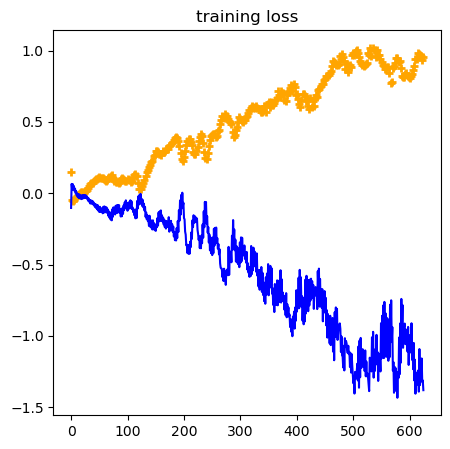

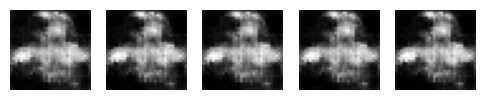

625it [00:47, 13.16it/s]


Epoch 1/30: gen_loss 0.8165243744716049, disc_loss -1.6622944890022278


<Figure size 2400x3000 with 0 Axes>

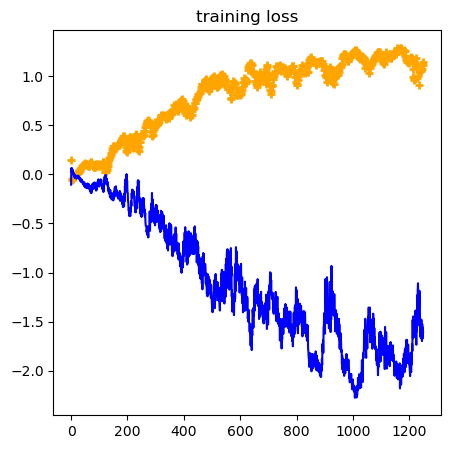

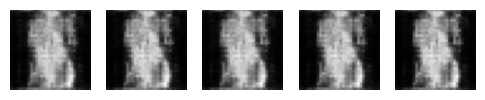

625it [00:47, 13.16it/s]


Epoch 2/30: gen_loss 1.161773015975952, disc_loss -1.906330885887146


<Figure size 2400x3000 with 0 Axes>

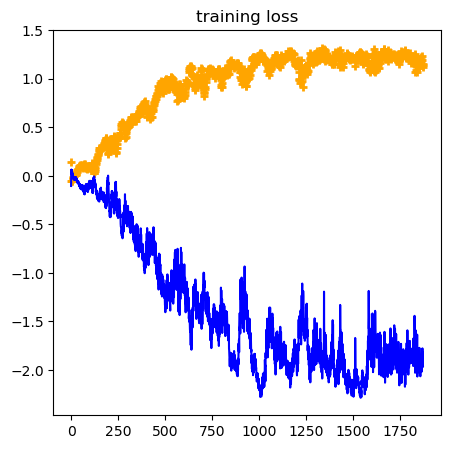

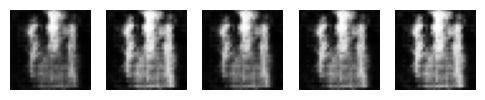

625it [00:47, 13.17it/s]


Epoch 3/30: gen_loss 1.0898823188781739, disc_loss -1.5732100281715393


<Figure size 2400x3000 with 0 Axes>

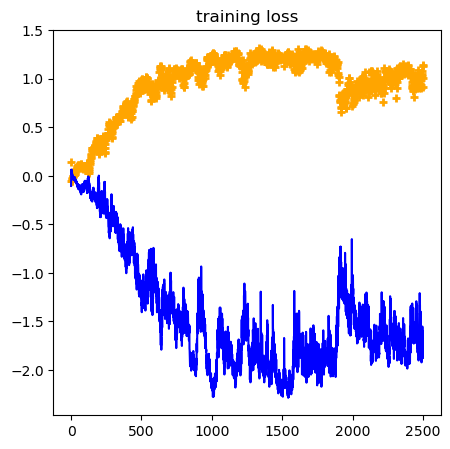

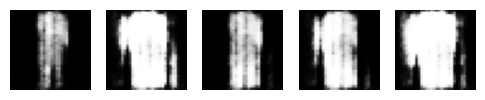

625it [00:47, 13.17it/s]


Epoch 4/30: gen_loss 0.998536148262024, disc_loss -1.6892778245925903


<Figure size 2400x3000 with 0 Axes>

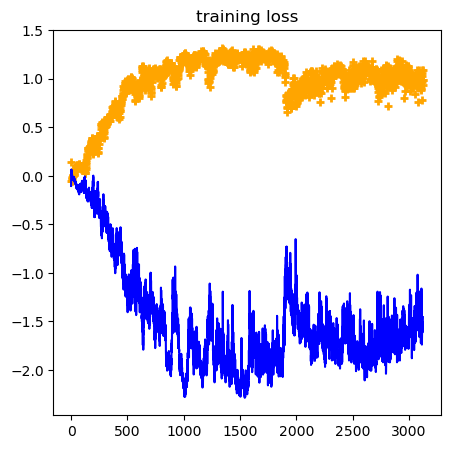

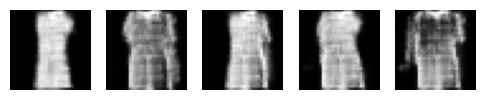

625it [00:47, 13.17it/s]


Epoch 5/30: gen_loss 0.9276069373130799, disc_loss -1.3594163179397583


<Figure size 2400x3000 with 0 Axes>

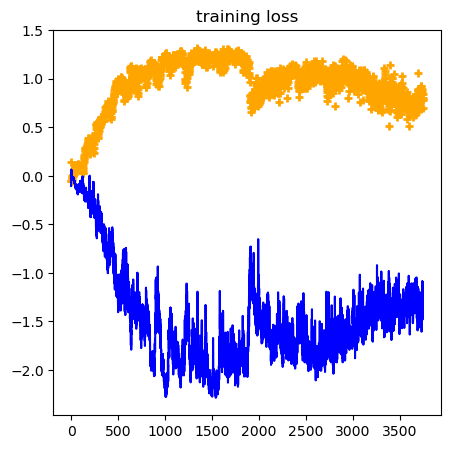

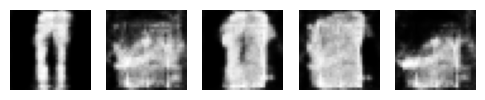

625it [00:47, 13.17it/s]


Epoch 6/30: gen_loss 0.8006649909973145, disc_loss -1.310514005279541


<Figure size 2400x3000 with 0 Axes>

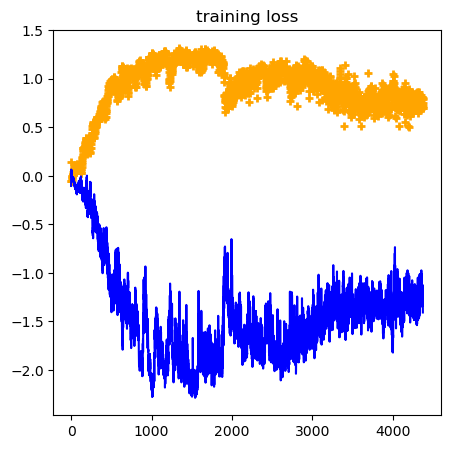

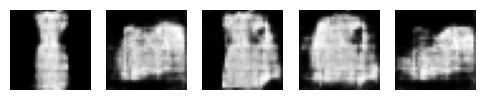

625it [00:47, 13.16it/s]


Epoch 7/30: gen_loss 0.7540971386909485, disc_loss -1.2361110529899597


<Figure size 2400x3000 with 0 Axes>

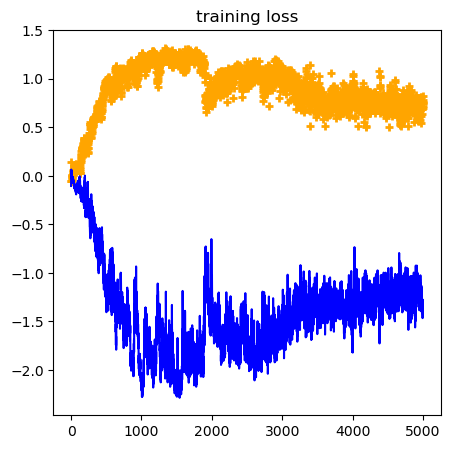

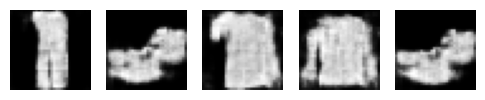

625it [00:47, 13.17it/s]


Epoch 8/30: gen_loss 0.7352246648311614, disc_loss -1.252090168094635


<Figure size 2400x3000 with 0 Axes>

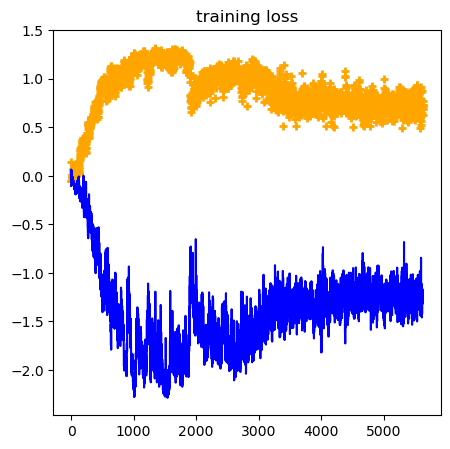

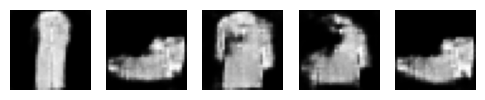

625it [00:47, 13.16it/s]


Epoch 9/30: gen_loss 0.7402920861721038, disc_loss -1.2505658036231995


<Figure size 2400x3000 with 0 Axes>

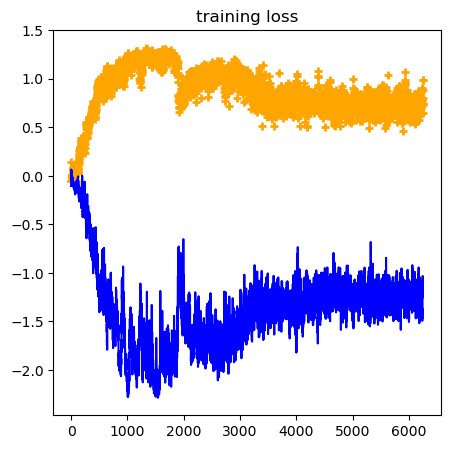

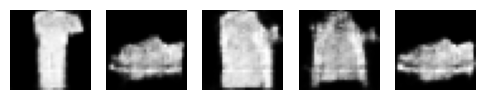

625it [00:47, 13.17it/s]


Epoch 10/30: gen_loss 0.7292904800415039, disc_loss -1.2273266085624694


<Figure size 2400x3000 with 0 Axes>

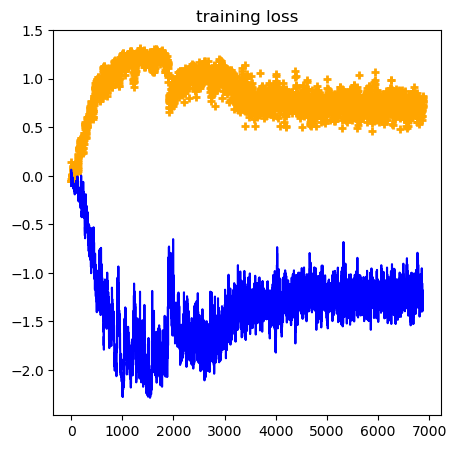

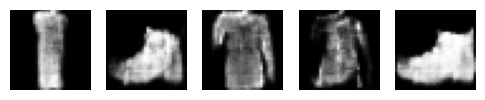

625it [00:47, 13.15it/s]


Epoch 11/30: gen_loss 0.7071436880588532, disc_loss -1.2311931879997253


<Figure size 2400x3000 with 0 Axes>

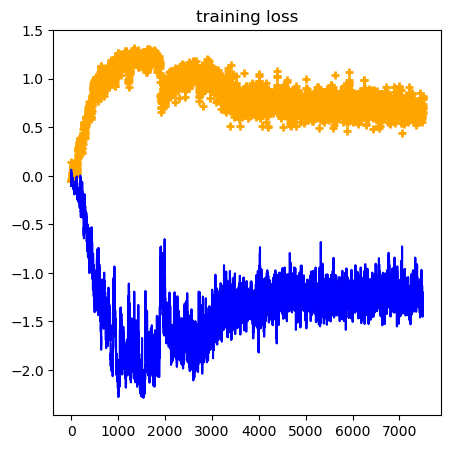

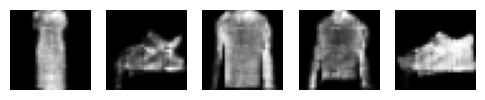

625it [00:47, 13.16it/s]


Epoch 12/30: gen_loss 0.6956546514511108, disc_loss -1.2369399876594545


<Figure size 2400x3000 with 0 Axes>

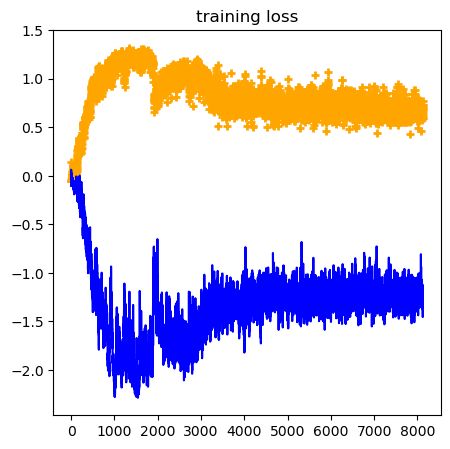

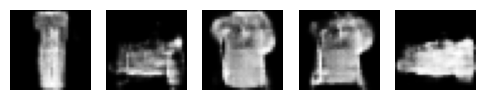

625it [00:47, 13.17it/s]


Epoch 13/30: gen_loss 0.6991316541194916, disc_loss -1.244093613910675


<Figure size 2400x3000 with 0 Axes>

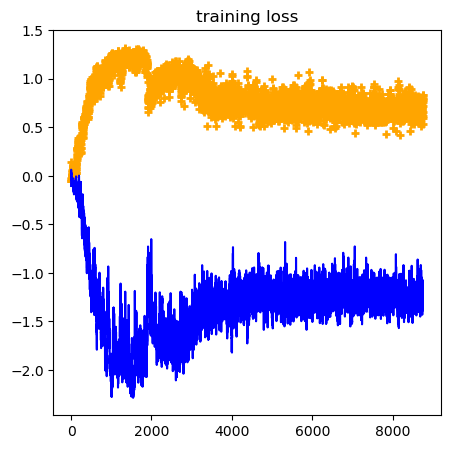

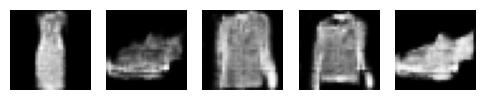

625it [00:47, 13.17it/s]


Epoch 14/30: gen_loss 0.7046125486850738, disc_loss -1.2479516240119934


<Figure size 2400x3000 with 0 Axes>

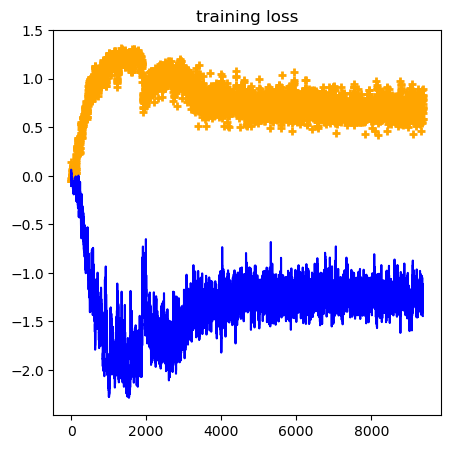

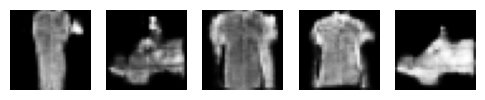

625it [00:47, 13.17it/s]


Epoch 15/30: gen_loss 0.6880377977848053, disc_loss -1.2055152151107789


<Figure size 2400x3000 with 0 Axes>

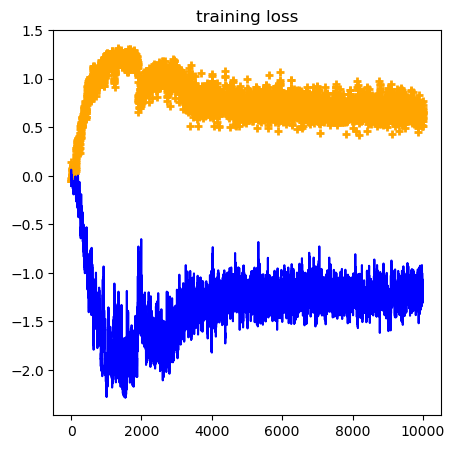

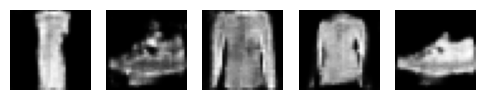

625it [00:47, 13.18it/s]


Epoch 16/30: gen_loss 0.6591564674377441, disc_loss -1.1705543663978577


<Figure size 2400x3000 with 0 Axes>

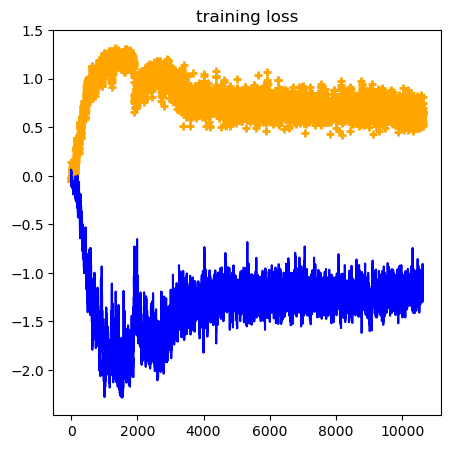

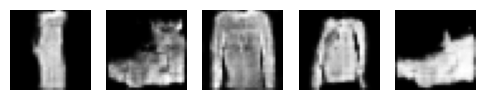

625it [00:47, 13.17it/s]


Epoch 17/30: gen_loss 0.6255360589981079, disc_loss -1.1313544234275819


<Figure size 2400x3000 with 0 Axes>

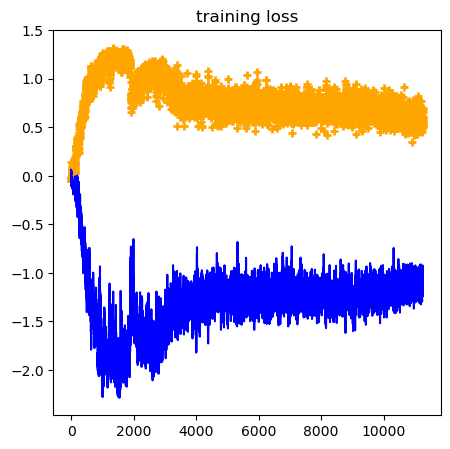

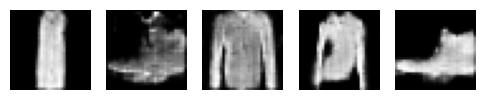

625it [00:47, 13.17it/s]


Epoch 18/30: gen_loss 0.593987856054306, disc_loss -1.1051038133621216


<Figure size 2400x3000 with 0 Axes>

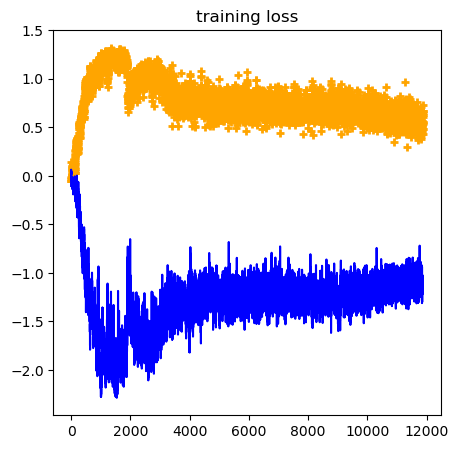

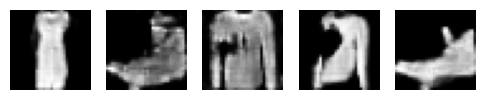

625it [00:47, 13.17it/s]


Epoch 19/30: gen_loss 0.5719951951026917, disc_loss -1.0729629258155822


<Figure size 2400x3000 with 0 Axes>

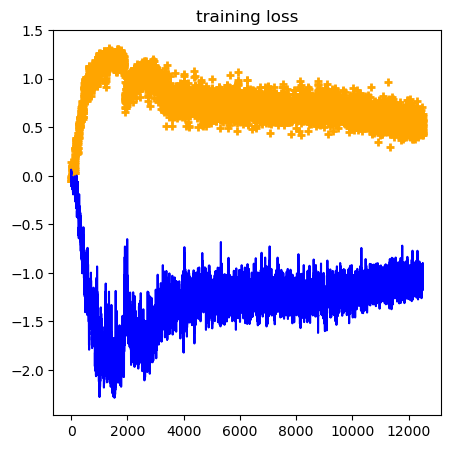

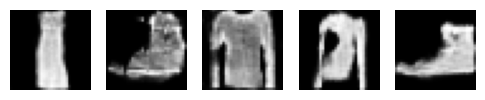

625it [00:47, 13.17it/s]


Epoch 20/30: gen_loss 0.5423889948368072, disc_loss -1.0520393837928772


<Figure size 2400x3000 with 0 Axes>

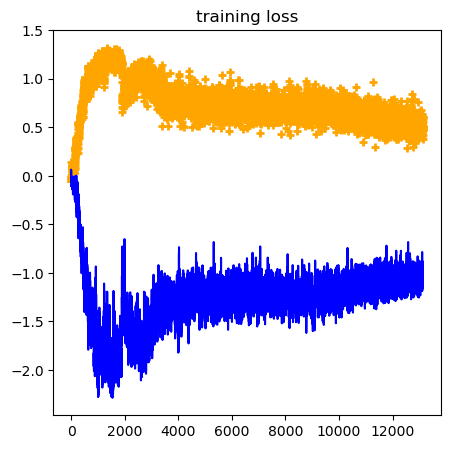

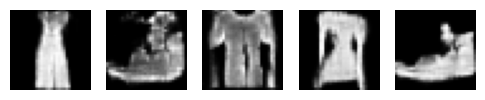

625it [00:47, 13.17it/s]


Epoch 21/30: gen_loss 0.5213942062139512, disc_loss -1.0289289445877075


<Figure size 2400x3000 with 0 Axes>

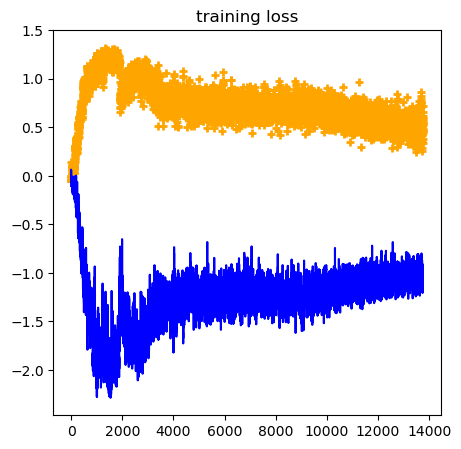

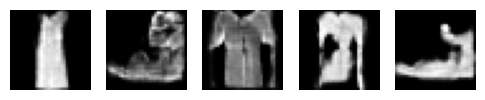

625it [00:47, 13.16it/s]


Epoch 22/30: gen_loss 0.5095861205339431, disc_loss -1.0158760800361633


<Figure size 2400x3000 with 0 Axes>

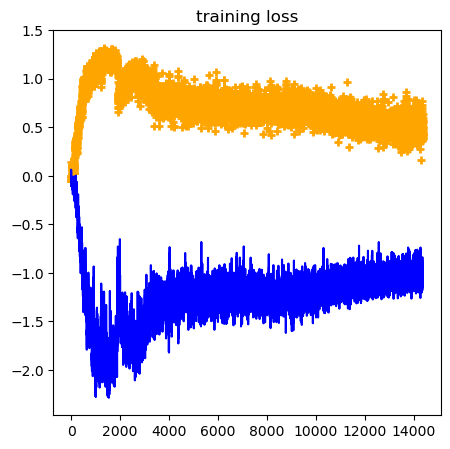

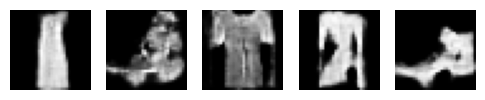

625it [00:47, 13.17it/s]


Epoch 23/30: gen_loss 0.5013305590629578, disc_loss -1.0079666027069092


<Figure size 2400x3000 with 0 Axes>

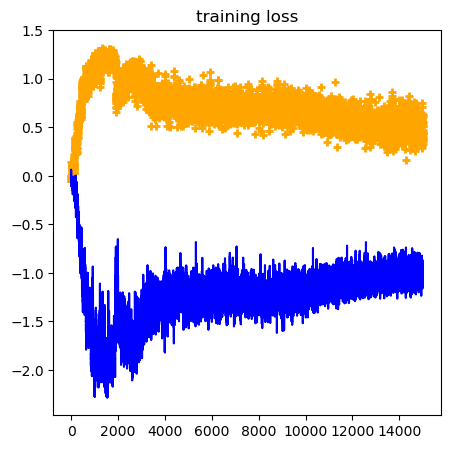

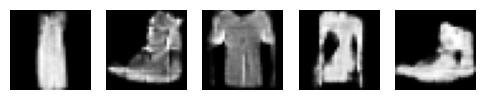

625it [00:47, 13.17it/s]


Epoch 24/30: gen_loss 0.49385789403915403, disc_loss -0.9970657183647156


<Figure size 2400x3000 with 0 Axes>

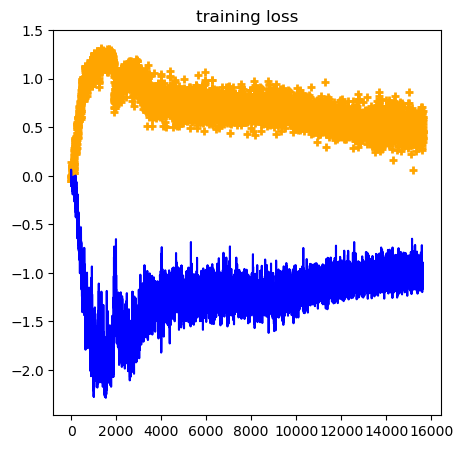

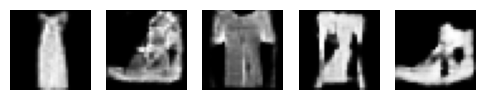

625it [00:47, 13.17it/s]


Epoch 25/30: gen_loss 0.48227933447360993, disc_loss -0.9755158958435058


<Figure size 2400x3000 with 0 Axes>

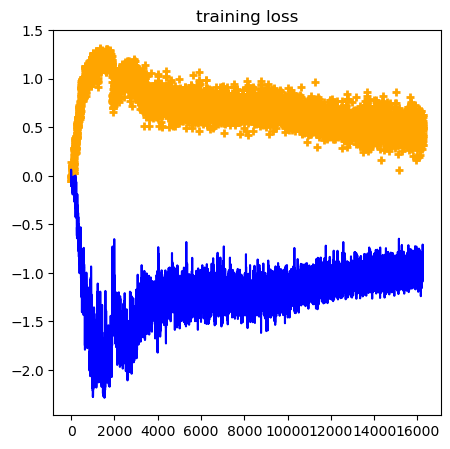

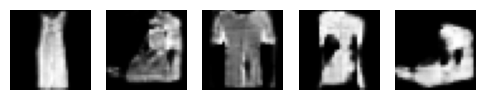

625it [00:47, 13.15it/s]


Epoch 26/30: gen_loss 0.4794991275548935, disc_loss -0.9594334991455078


<Figure size 2400x3000 with 0 Axes>

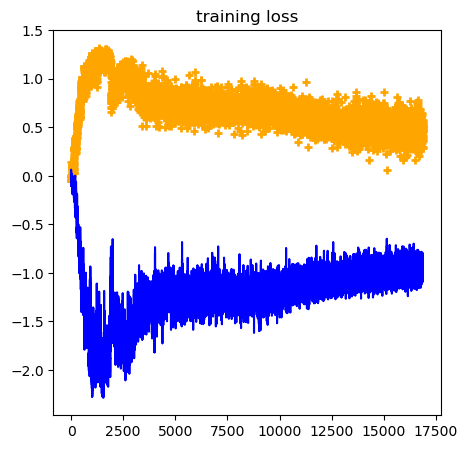

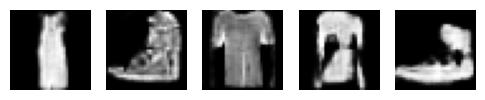

625it [00:47, 13.17it/s]


Epoch 27/30: gen_loss 0.4746159089565277, disc_loss -0.9449865772247314


<Figure size 2400x3000 with 0 Axes>

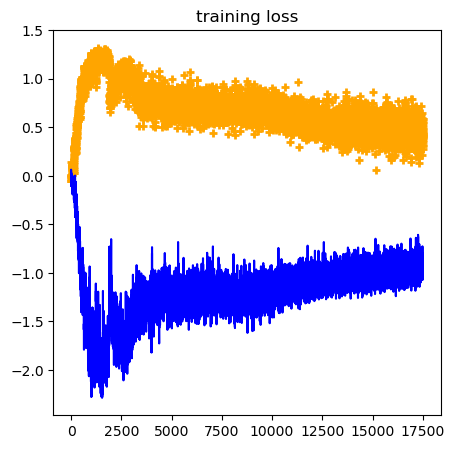

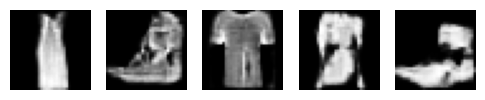

625it [00:47, 13.17it/s]


Epoch 28/30: gen_loss 0.4669553251564503, disc_loss -0.9330430994033814


<Figure size 2400x3000 with 0 Axes>

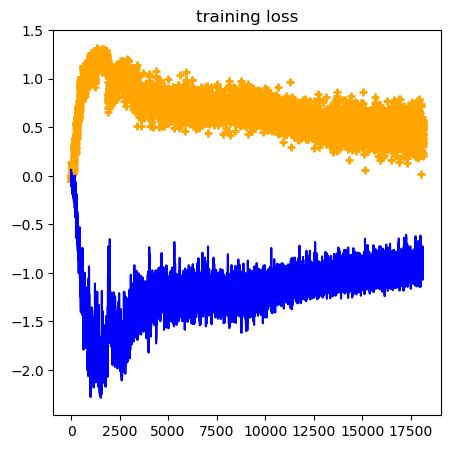

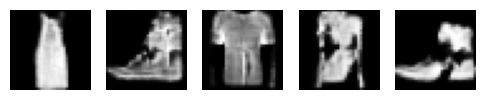

405it [00:30, 13.19it/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# You are allowed to change hyperparameters
# Although, if you implemented everything correctly this hyperparmeters should work
lr_gen = 0.00007
lr_disc = 0.00005
batch_size = 64
weight_cliping_limit = 0.01
n_critic_steps = 2
n_image_channels = 1  #3 if RGB and 1 if Greyscale

gen = Generator(in_channels=100, out_channels=n_image_channels)
disc = Discriminator(in_channels=n_image_channels)

print(gen.apply(weights_init))
print(disc.apply(weights_init))

gen.to(device)
disc.to(device)

# assert for you to check the correctness of the sizes of models outputs
z = torch.rand((4, 100, 1, 1), device=device)
fake_image = gen(z)
assert list(fake_image.shape) == [4, n_image_channels, 32, 32]
assert list(disc(fake_image).shape) == [4, 1, 1, 1]


# WGAN with gradient clipping uses RMSprop instead of ADAM
optimizer_gen = torch.optim.RMSprop(gen.parameters(), lr=lr_gen)
optimizer_disc = torch.optim.RMSprop(disc.parameters(), lr=lr_disc)

train_loader = load_fashion_mnist_dataset(batch_size)

#initialise the trainer
trainer = WGANTrainer(model_gen=gen, model_disc=disc,
                        optimizer_gen=optimizer_gen, optimizer_disc=optimizer_disc,
                        n_disc_steps=n_critic_steps, weight_cliping=weight_cliping_limit, device=device)

#train WGAN
trainer.train(n_epoches=30, train_loader=train_loader)
